In [7]:
## Step 1: Load the Dataset
import pandas as pd

# Loading datasets
df = pd.read_csv(r'C:\Users\brivi\Downloads\My Portfolio\inventory-forecasting-project\data\unstructured_sku_sales_data.csv')

# Previewing top 5 rows
df.head()


,SKU_ID,Category,Vendor,Week,Store_Location,Units_Sold,Unit_Cost,Lead_Time_Days
0,SKU_0359,Electronics,Vendor_1,42,Store_10,18.0,75.95,29
1,SKU_0062,Toys,Vendor_10,51,Store_13,16.0,14.50,7
2,SKU_0458,Home & Kitchen,Vendor_1,38,Store_15,5.0,109.42,22
3,SKU_0346,Clothing,Vendor_7,35,Store_12,25.0,98.35,7
4,SKU_0188,Electronics,Vendor_5,23,Store_9,25.0,188.68,16


In [9]:
# Checking if there are missing values
df.isnull().sum()

SKU_ID               0
Category             0
Vendor               0
Week                 0
Store_Location    1040
Units_Sold        1040
Unit_Cost            0
Lead_Time_Days       0
dtype: int64

In [11]:
# Both the Store_Location and Units_Sold have same number of missing values: 1040
# Since 1040 missing values are significant portion of the total number of data
# We'll investigate further by chyecking if all 1040 rows belong to the same week/SKU
# Or if they're concentrated in a few vendors or categories
df[df['Units_Sold'].isnull()]['Vendor'].value_counts()

Vendor
Vendor_2     130
Vendor_3     114
Vendor_10    109
Vendor_1     108
Vendor_7     105
Vendor_9     105
Vendor_8     103
Vendor_5      99
Vendor_6      91
Vendor_4      76
Name: count, dtype: int64

In [46]:
df = df.dropna(subset=['Store_Location', 'Units_Sold'])
df.isnull().sum()

SKU_ID            0
Category          0
Vendor            0
Week              0
Store_Location    0
Units_Sold        0
Unit_Cost         0
Lead_Time_Days    0
dtype: int64

## Step 2: Handling Missing Values
- A total of 1,040 rows had missing values in both 'Store_Location' and 'Units_Sold'. These rows were distributed across all vendors, 
- indicating systemic data issues rather than a specific vendor problem. Since 'Units_Sold' is essential for demand forecasting, 
- these records were removed to maintain the integrity of the dataset.

In [17]:
df.shape

(49945, 8)

In [21]:
df.dtypes

SKU_ID             object
Category           object
Vendor             object
Week                int64
Store_Location     object
Units_Sold        float64
Unit_Cost         float64
Lead_Time_Days      int64
dtype: object

In [38]:
df['Category'] = df['Category'].astype('category')
df['Vendor'] = df['Vendor'].astype('category')
df['Store_Location'] = df['Store_Location'].astype('category')
df['Units_Sold'] = df['Units_Sold'].astype(int)

df.dtypes

SKU_ID              object
Category          category
Vendor            category
Week                 int64
Store_Location    category
Units_Sold           int32
Unit_Cost          float64
Lead_Time_Days       int64
dtype: object

## Step 3: Fixing Data Types

- Converted 'Category', 'Vendor', and 'Store_Location' to categorical types to improve memory efficiency and enable faster grouping.
- Checked 'Units_Sold' and confirmed all values were whole numbers, so converted from float to integer.


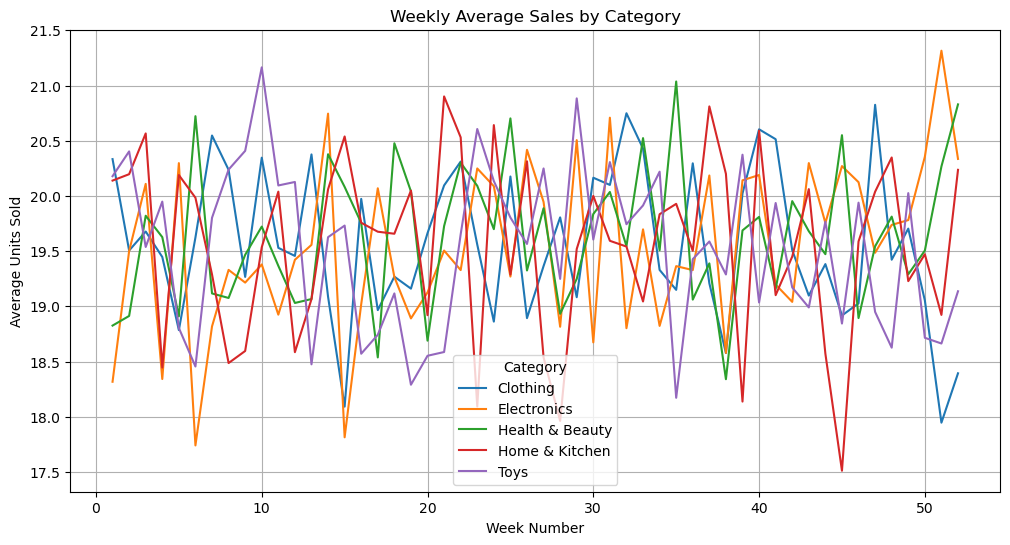

In [80]:
weekly_sales = df.groupby(['Category', 'Week'], observed=True)['Units_Sold'].mean().reset_index()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_sales, x='Week', y='Units_Sold', hue='Category')
plt.title('Weekly Average Sales by Category')
plt.ylabel('Average Units Sold')
plt.xlabel('Week Number')
plt.grid(True)
plt.savefig(r'C:\Users\brivi\Downloads\My Portfolio\inventory-forecasting-project\visualizations\weekly_sales_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

## Weekly Average Sales by Category

This line plot shows how average weekly sales vary across product categories. It reveals seasonal demand trends — for example, some categories show consistent demand, while others peak during specific weeks. These insights are critical for aligning inventory planning with demand cycles.


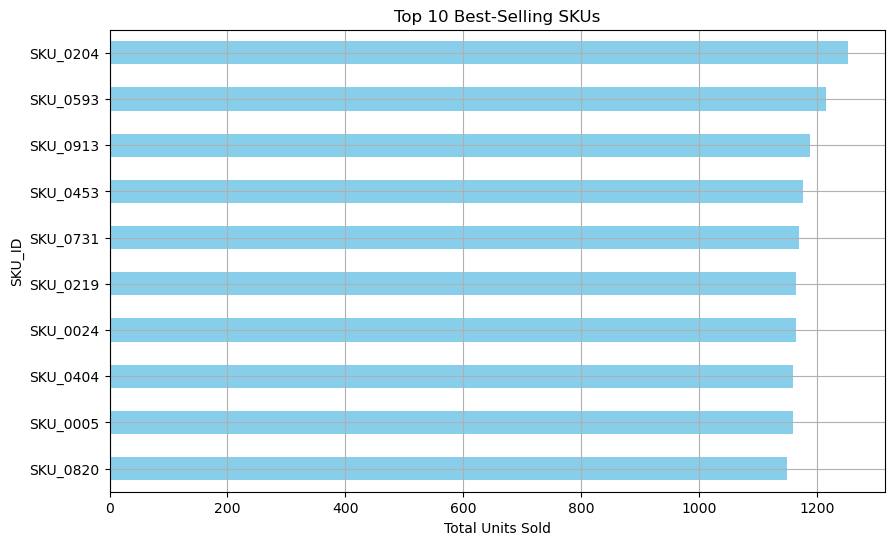

In [82]:
top_skus = df.groupby('SKU_ID')['Units_Sold'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
top_skus.plot(kind='barh', color='skyblue')
plt.title('Top 10 Best-Selling SKUs')
plt.xlabel('Total Units Sold')
plt.gca().invert_yaxis()  # Highest on top                                      
plt.grid(True)
plt.savefig(r'C:\Users\brivi\Downloads\My Portfolio\inventory-forecasting-project\visualizations\top_10_skus.png', dpi=300, bbox_inches='tight')
plt.show()

## Top 10 Best-Selling SKUs

This horizontal bar chart highlights the top-performing SKUs based on total units sold. These products should be prioritized in forecasting and stock replenishment efforts due to their significant contribution to overall sales volume.


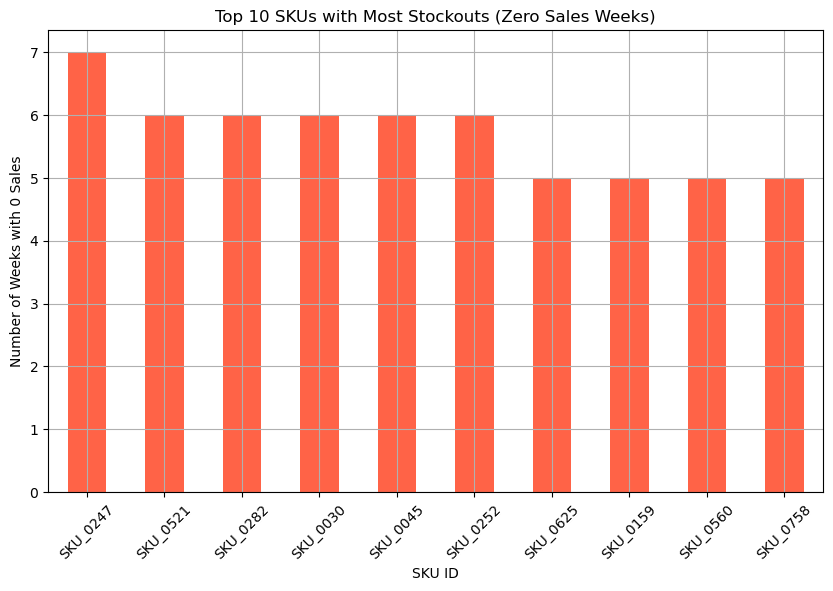

In [84]:
stockouts = df[df['Units_Sold'] == 0].groupby('SKU_ID').size().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
stockouts.plot(kind='bar', color='tomato')
plt.title('Top 10 SKUs with Most Stockouts (Zero Sales Weeks)')
plt.ylabel('Number of Weeks with 0 Sales')
plt.xlabel('SKU ID')
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig(r'C:\Users\brivi\Downloads\My Portfolio\inventory-forecasting-project\visualizations\stockout_skus.png', dpi=300, bbox_inches='tight')
plt.show()


## Stockout Analysis: SKUs with Most Weeks of Zero Sales

This chart identifies SKUs with the highest number of zero-sales weeks, potentially indicating frequent stockouts or very low demand. These products may require revised stocking strategies or further investigation.


C:\Users\brivi\AppData\Local\Temp\ipykernel_24088\4011857324.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vendor_summary = df.groupby('Vendor').agg({


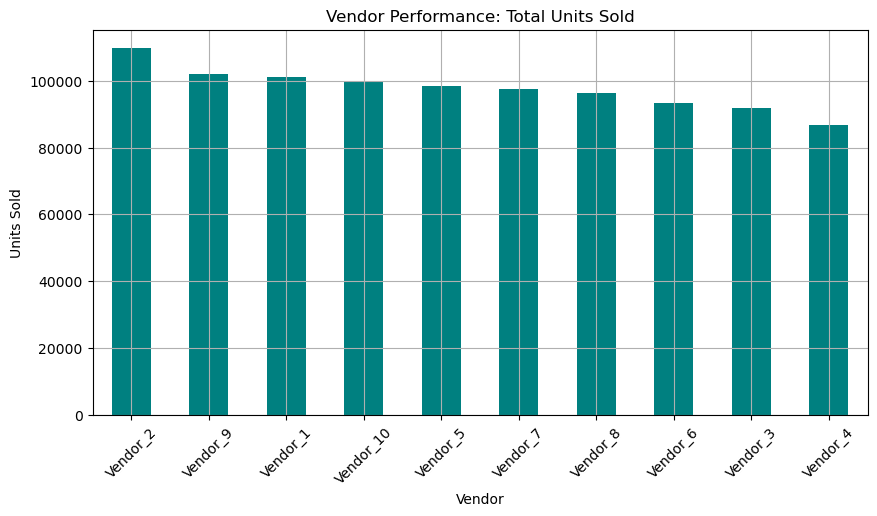

In [86]:
vendor_summary = df.groupby('Vendor').agg({
    'Units_Sold': 'sum',
    'Lead_Time_Days': 'mean'
}).sort_values(by='Units_Sold', ascending=False)

vendor_summary.plot(kind='bar', y='Units_Sold', legend=False, color='teal', figsize=(10, 5))
plt.title('Vendor Performance: Total Units Sold')
plt.ylabel('Units Sold')
plt.grid(True)
plt.xticks(rotation=45)
plt.savefig(r'C:\Users\brivi\Downloads\My Portfolio\inventory-forecasting-project\visualizations\vendor_performance.png', dpi=300, bbox_inches='tight')
plt.show()


## Vendor Performance: Total Sales and Lead Time

This summary ranks vendors by total units sold and highlights their average lead times. Vendors with high sales and low lead times are strategic partners, while others may require negotiation or lead time improvements to optimize supply chain efficiency.


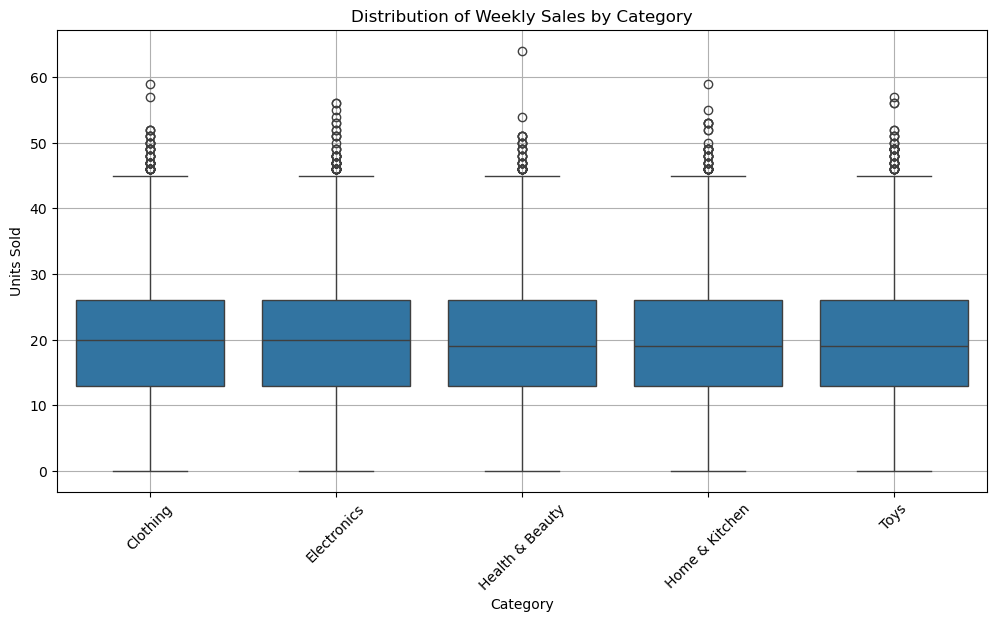

In [88]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Category', y='Units_Sold')
plt.title('Distribution of Weekly Sales by Category')
plt.ylabel('Units Sold')
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig(r'C:\Users\brivi\Downloads\My Portfolio\inventory-forecasting-project\visualizations\sales_variability_by_category.png', dpi=300, bbox_inches='tight')
plt.show()


## Weekly Sales Distribution by Category

The boxplot shows the distribution and variability of weekly sales across categories. Wider boxes or more outliers indicate greater fluctuation in weekly sales, which may signal demand instability or supply challenges.


In [75]:
# Save the cleaned dataset to the 'data' directory
df.to_csv('../data/cleaned_sku_sales_data.csv', index=False)


## Export Cleaned Dataset

The final cleaned dataset was saved as 'cleaned_sku_sales_data.csv' in the project’s /data directory. 
This file will be used in the forecasting and replenishment phases of the project.
